<a href="https://www.kaggle.com/code/osmanural/employees-evaluation-for-promotion?scriptVersionId=209028652" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import warnings
import numpy as np
import joblib
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder,MinMaxScaler
warnings.simplefilter(action='ignore', category=Warning)
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import (
    classification_report, 
    roc_auc_score, 
    roc_curve, 
    auc, 
    confusion_matrix, 
    ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt



import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

employeeid: Çalışanın benzersiz kimlik numarası.  
department: Çalışanın bağlı olduğu departman.  
region: Çalışanın bulunduğu bölge.   
education: Çalışanın eğitim düzeyi.  
gender: Çalışanın cinsiyeti.  
recruitmentchannel: Çalışanın işe alındığı kanal.   
no of trainings: Çalışanın önceki yıl tamamladığı eğitim sayısı (yumuşak beceriler, teknik beceriler vb.). 
age: Çalışanın yaşı.  
previous year rating: Çalışanın önceki yıl aldığı performans değerlendirme puanı.  
length of service: Çalışanın hizmet süresi (yıl olarak).  
awards_won: Çalışanın önceki yıl ödül kazanıp kazanmadığı (1: kazandı, 0: kazanmadı).  
avg training score: Çalışanın mevcut eğitim değerlendirmelerindeki ortalama puanı.  
is_promoted: (Hedef) Çalışanın terfiye aday olup olmadığı (1: önerildi, 0: önerilmedi).  

In [2]:
data=pd.read_csv("/kaggle/input/employepromotionn/employee_promotion.csv")

In [3]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())

In [4]:
check_df(data)

##################### Shape #####################
(54808, 13)
##################### Types #####################
employee_id               int64
department               object
region                   object
education                object
gender                   object
recruitment_channel      object
no_of_trainings           int64
age                       int64
previous_year_rating    float64
length_of_service         int64
awards_won                int64
avg_training_score      float64
is_promoted               int64
dtype: object
##################### Head #####################
   employee_id         department     region         education gender recruitment_channel  no_of_trainings  age  previous_year_rating  length_of_service  awards_won  avg_training_score  is_promoted
0        65438  Sales & Marketing   region_7  Master's & above      f            sourcing                1   35                   5.0                  8           0                49.0            0
1        6514

In [5]:
data.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,0,49.0,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,60.0,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,50.0,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,50.0,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,73.0,0


In [6]:

for col in data.columns:
    print(f"Sütun Adı: {data[col].name} \n"
          f"Benzersiz Değer Sayısı : {data[col].nunique()}")

Sütun Adı: employee_id 
Benzersiz Değer Sayısı : 54808
Sütun Adı: department 
Benzersiz Değer Sayısı : 9
Sütun Adı: region 
Benzersiz Değer Sayısı : 34
Sütun Adı: education 
Benzersiz Değer Sayısı : 3
Sütun Adı: gender 
Benzersiz Değer Sayısı : 2
Sütun Adı: recruitment_channel 
Benzersiz Değer Sayısı : 3
Sütun Adı: no_of_trainings 
Benzersiz Değer Sayısı : 10
Sütun Adı: age 
Benzersiz Değer Sayısı : 41
Sütun Adı: previous_year_rating 
Benzersiz Değer Sayısı : 5
Sütun Adı: length_of_service 
Benzersiz Değer Sayısı : 35
Sütun Adı: awards_won 
Benzersiz Değer Sayısı : 2
Sütun Adı: avg_training_score 
Benzersiz Değer Sayısı : 59
Sütun Adı: is_promoted 
Benzersiz Değer Sayısı : 2


In [7]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(data, cat_th=5, car_th=20)

Observations: 54808
Variables: 13
cat_cols: 6
num_cols: 6
cat_but_car: 1
num_but_cat: 2


In [8]:
print(cat_cols)
print(num_cols)
print(cat_but_car)

['department', 'education', 'gender', 'recruitment_channel', 'awards_won', 'is_promoted']
['employee_id', 'no_of_trainings', 'age', 'previous_year_rating', 'length_of_service', 'avg_training_score']
['region']


In [9]:
# Numeric columns listesine eklemek ve kolonları düzenlemek için
# previous_year_rating kolonunu numeric hale getir
data['previous_year_rating'] = pd.to_numeric(data['previous_year_rating'], errors='coerce')

# Kategorik versiyonu varsa sil (örneğin kategorik ad aynıysa)
if 'previous_year_rating_cat' in data.columns:
    data.drop(columns=['previous_year_rating_cat'], inplace=True)

# Numeric kolonlar listesine ekle
if 'previous_year_rating' not in num_cols:
    num_cols.append('previous_year_rating')

print("Güncellenmiş numeric kolonlar listesi:", num_cols)

Güncellenmiş numeric kolonlar listesi: ['employee_id', 'no_of_trainings', 'age', 'previous_year_rating', 'length_of_service', 'avg_training_score']


In [10]:
cat_cols=['department', 'region', 'education', 'gender', 'recruitment_channel', 'is_promoted']

In [11]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)

In [12]:
for i in cat_cols:
    cat_summary(data,i)

                   department      Ratio
department                              
Sales & Marketing       16840  30.725442
Operations              11348  20.705007
Technology               7138  13.023646
Procurement              7138  13.023646
Analytics                5352   9.764998
Finance                  2536   4.627062
HR                       2418   4.411765
Legal                    1039   1.895709
R&D                       999   1.822727
##########################################
           region      Ratio
region                      
region_2    12343  22.520435
region_22    6428  11.728215
region_7     4843   8.836301
region_15    2808   5.123340
region_13    2648   4.831411
region_26    2260   4.123486
region_31    1935   3.530506
region_4     1703   3.107211
region_27    1659   3.026930
region_16    1465   2.672967
region_28    1318   2.404758
region_11    1315   2.399285
region_23    1175   2.143848
region_29     994   1.813604
region_32     945   1.724201
region_19    

In [13]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [ 0.25, 0.50,  0.75]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

In [14]:
for col in num_cols:
    num_summary(data,col)

count    54808.000000
mean     39195.830627
std      22586.581449
min          1.000000
25%      19669.750000
50%      39225.500000
75%      58730.500000
max      78298.000000
Name: employee_id, dtype: float64
count    54808.000000
mean         1.253011
std          0.609264
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         10.000000
Name: no_of_trainings, dtype: float64
count    54808.000000
mean        34.803915
std          7.660169
min         20.000000
25%         29.000000
50%         33.000000
75%         39.000000
max         60.000000
Name: age, dtype: float64
count    50684.000000
mean         3.329256
std          1.259993
min          1.000000
25%          3.000000
50%          3.000000
75%          4.000000
max          5.000000
Name: previous_year_rating, dtype: float64
count    54808.000000
mean         5.865512
std          4.265094
min          1.000000
25%          3.000000
50%          5.000000
75%          7.000000
m

In [15]:
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

In [16]:
for col in num_cols:
    target_summary_with_num(data,"is_promoted",col)

              employee_id
is_promoted              
0            39187.520423
1            39285.092331


             no_of_trainings
is_promoted                 
0                   1.257639
1                   1.203299


                   age
is_promoted           
0            34.844037
1            34.372965


             previous_year_rating
is_promoted                      
0                        3.267911
1                        3.986140


             length_of_service
is_promoted                   
0                     5.879398
1                     5.716367


             avg_training_score
is_promoted                    
0                     62.947673
1                     71.842574




In [17]:
def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")

In [18]:
for col in cat_cols:
    target_summary_with_cat(data,"is_promoted",col)

                   TARGET_MEAN
department                    
Analytics             0.095665
Finance               0.081230
HR                    0.056245
Legal                 0.051011
Operations            0.090148
Procurement           0.096386
R&D                   0.069069
Sales & Marketing     0.072031
Technology            0.107593


           TARGET_MEAN
region                
region_1      0.095082
region_10     0.078704
region_11     0.056274
region_12     0.066000
region_13     0.086858
region_14     0.074970
region_15     0.079060
region_16     0.069625
region_17     0.136935
region_18     0.032258
region_19     0.060641
region_2      0.080126
region_20     0.057647
region_21     0.043796
region_22     0.114188
region_23     0.116596
region_24     0.035433
region_25     0.125763
region_26     0.063274
region_27     0.078963
region_28     0.116844
region_29     0.043260
region_3      0.106936
region_30     0.089802
region_31     0.056848
region_32     0.042328
region_33    

In [19]:
def correlation_matrix(df, cols):
    fig = plt.gcf()
    fig.set_size_inches(10, 8)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    fig = sns.heatmap(df[cols].corr(), annot=True, linewidths=0.5, annot_kws={'size': 12}, linecolor='w', cmap='RdBu')
    plt.show(block=True)

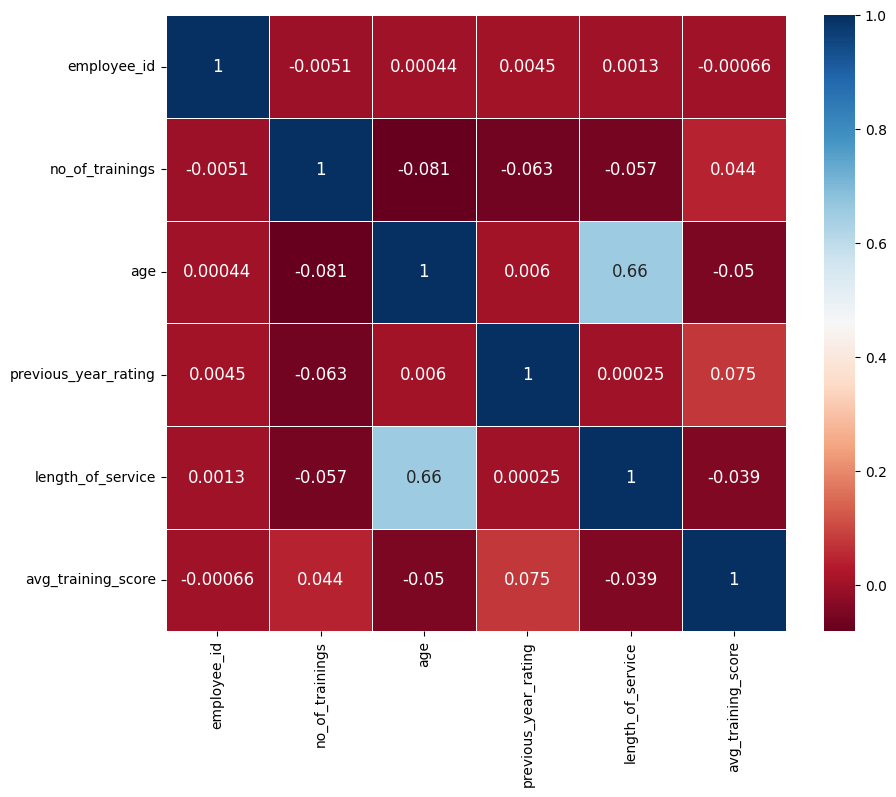

In [20]:
correlation_matrix(data,num_cols)

In [21]:
# Age için gruplama fonksiyonu
def age_group_custom(age):
    if age <= 25:
        return "20-25"
    elif age <= 30:
        return "26-30"
    elif age <= 35:
        return "31-35"
    elif age <= 40:
        return "36-40"
    elif age <= 50:
        return "41-50"
    else:
        return "51+"

# Length of Service (Kıdem) için gruplama fonksiyonu
def service_group_custom(service):
    if service == 1:
        return "1 yıl"
    elif service <= 2:
        return "1-2 yıl"
    elif service <= 3:
        return "2-3 yıl"
    elif service <= 5:
        return "3-5 yıl"
    elif service <= 10:
        return "5-10 yıl"
    elif service <= 15:
        return "10-15 yıl"
    else:
        return "15+ yıl"

# Grupları oluşturma
data["age_group"] = data["age"].apply(age_group_custom)
data["service_group"] = data["length_of_service"].apply(service_group_custom)

# One-hot encoding uygulama
data = pd.get_dummies(data, columns=["age_group", "service_group"], drop_first=True)

# İlk birkaç satırı görüntüleme
data.head()


,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won,avg_training_score,is_promoted,age_group_26-30,age_group_31-35,age_group_36-40,age_group_41-50,age_group_51+,service_group_1-2 yıl,service_group_10-15 yıl,service_group_15+ yıl,service_group_2-3 yıl,service_group_3-5 yıl,service_group_5-10 yıl
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,0,49.0,0,False,True,False,False,False,False,False,False,False,False,True
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,60.0,0,True,False,False,False,False,False,False,False,False,True,False
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,50.0,0,False,True,False,False,False,False,False,False,False,False,True
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,50.0,0,False,False,True,False,False,False,False,False,False,False,True
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,73.0,0,False,False,False,True,False,True,False,False,False,False,False


In [22]:
# Function to group avg_training_score
def training_score_group(score):
    if score <= 60:
        return "Failing"
    elif score <= 79:
        return "Successful"
    else:
        return "Very Successful"

# Apply the function to create a new column
data["training_score_group"] = data["avg_training_score"].apply(training_score_group)

# One-hot encode the new column
data = pd.get_dummies(data, columns=["training_score_group"], drop_first=True)

# Display the first few rows of the updated dataset
data.head()


,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won,avg_training_score,is_promoted,age_group_26-30,age_group_31-35,age_group_36-40,age_group_41-50,age_group_51+,service_group_1-2 yıl,service_group_10-15 yıl,service_group_15+ yıl,service_group_2-3 yıl,service_group_3-5 yıl,service_group_5-10 yıl,training_score_group_Successful,training_score_group_Very Successful
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,0,49.0,0,False,True,False,False,False,False,False,False,False,False,True,False,False
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,60.0,0,True,False,False,False,False,False,False,False,False,True,False,False,False
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,50.0,0,False,True,False,False,False,False,False,False,False,False,True,False,False
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,50.0,0,False,False,True,False,False,False,False,False,False,False,True,False,False
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,73.0,0,False,False,False,True,False,True,False,False,False,False,False,True,False


In [23]:
data.drop(columns=["age", "length_of_service", "avg_training_score"],inplace=True)

In [24]:
data=pd.read_excel("/kaggle/input/datasonhali/data_son_featured.xlsx")

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 21 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   department                            54808 non-null  object 
 1   education                             52399 non-null  object 
 2   gender                                54808 non-null  object 
 3   recruitment_channel                   54808 non-null  object 
 4   no_of_trainings                       54808 non-null  int64  
 5   previous_year_rating                  50684 non-null  float64
 6   KPIs_met >80%                         54808 non-null  int64  
 7   is_promoted                           54808 non-null  int64  
 8   age_group_26-30                       54808 non-null  bool   
 9   age_group_31-35                       54808 non-null  bool   
 10  age_group_36-40                       54808 non-null  bool   
 11  age_group_41-50

In [26]:
# # Visualize distribution of numeric features
# data[num_cols].hist(figsize=(18, 12), bins=20, layout=(5, 3))
# plt.tight_layout()
# plt.show()

In [27]:
# # Box plots of numeric features to see outliers and distributions
# plt.figure(figsize=(14, 10))
# sns.boxplot(data=data[num_cols])
# plt.xticks(rotation=90)
# plt.title('Box Plot of Numeric Features')
# plt.show()

In [28]:
missing_values = data.isnull().sum()
print("\nMissing values in the dataset:\n", missing_values)


Missing values in the dataset:
 department                                 0
education                               2409
gender                                     0
recruitment_channel                        0
no_of_trainings                            0
previous_year_rating                    4124
KPIs_met >80%                              0
is_promoted                                0
age_group_26-30                            0
age_group_31-35                            0
age_group_36-40                            0
age_group_41-50                            0
age_group_51+                              0
service_group_1-2 yıl                      0
service_group_10-15 yıl                    0
service_group_15+ yıl                      0
service_group_2-3 yıl                      0
service_group_3-5 yıl                      0
service_group_5-10 yıl                     0
training_score_group_Successful            0
training_score_group_Very Successful       0
dtype: int64


<Figure size 1400x800 with 0 Axes>

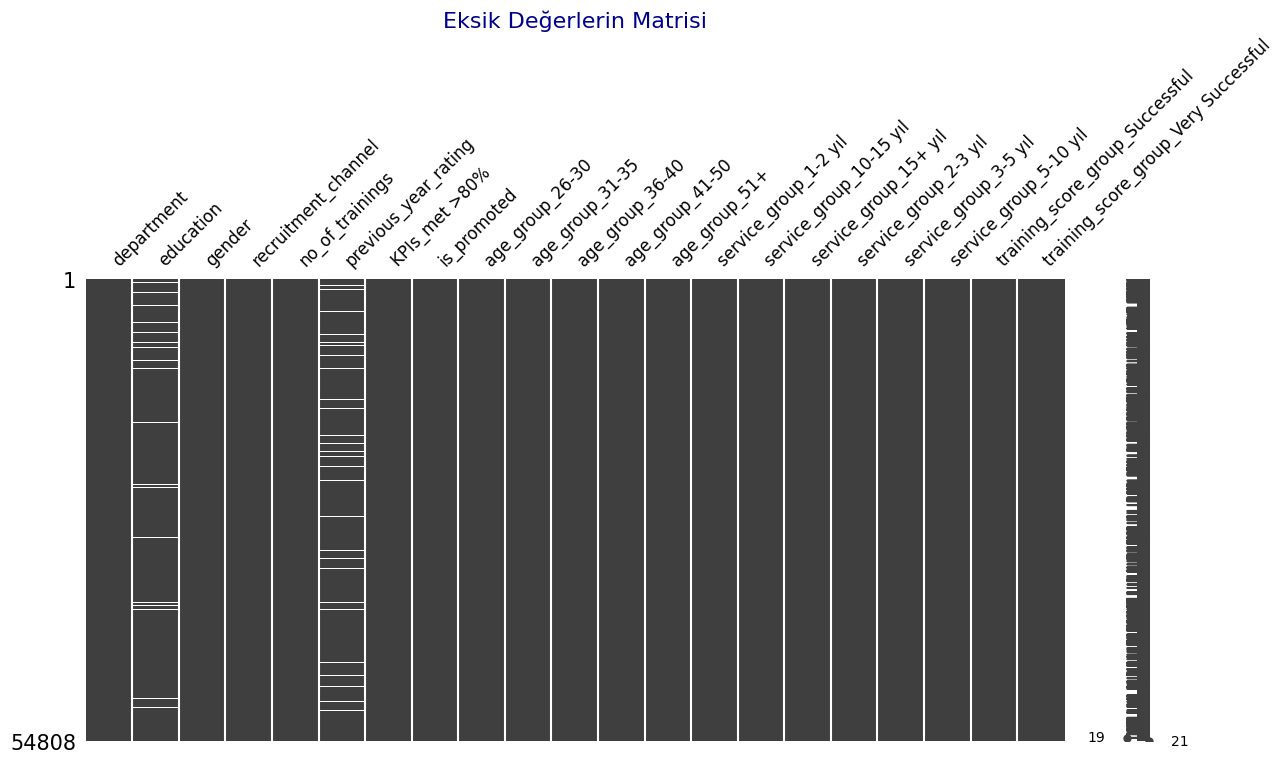

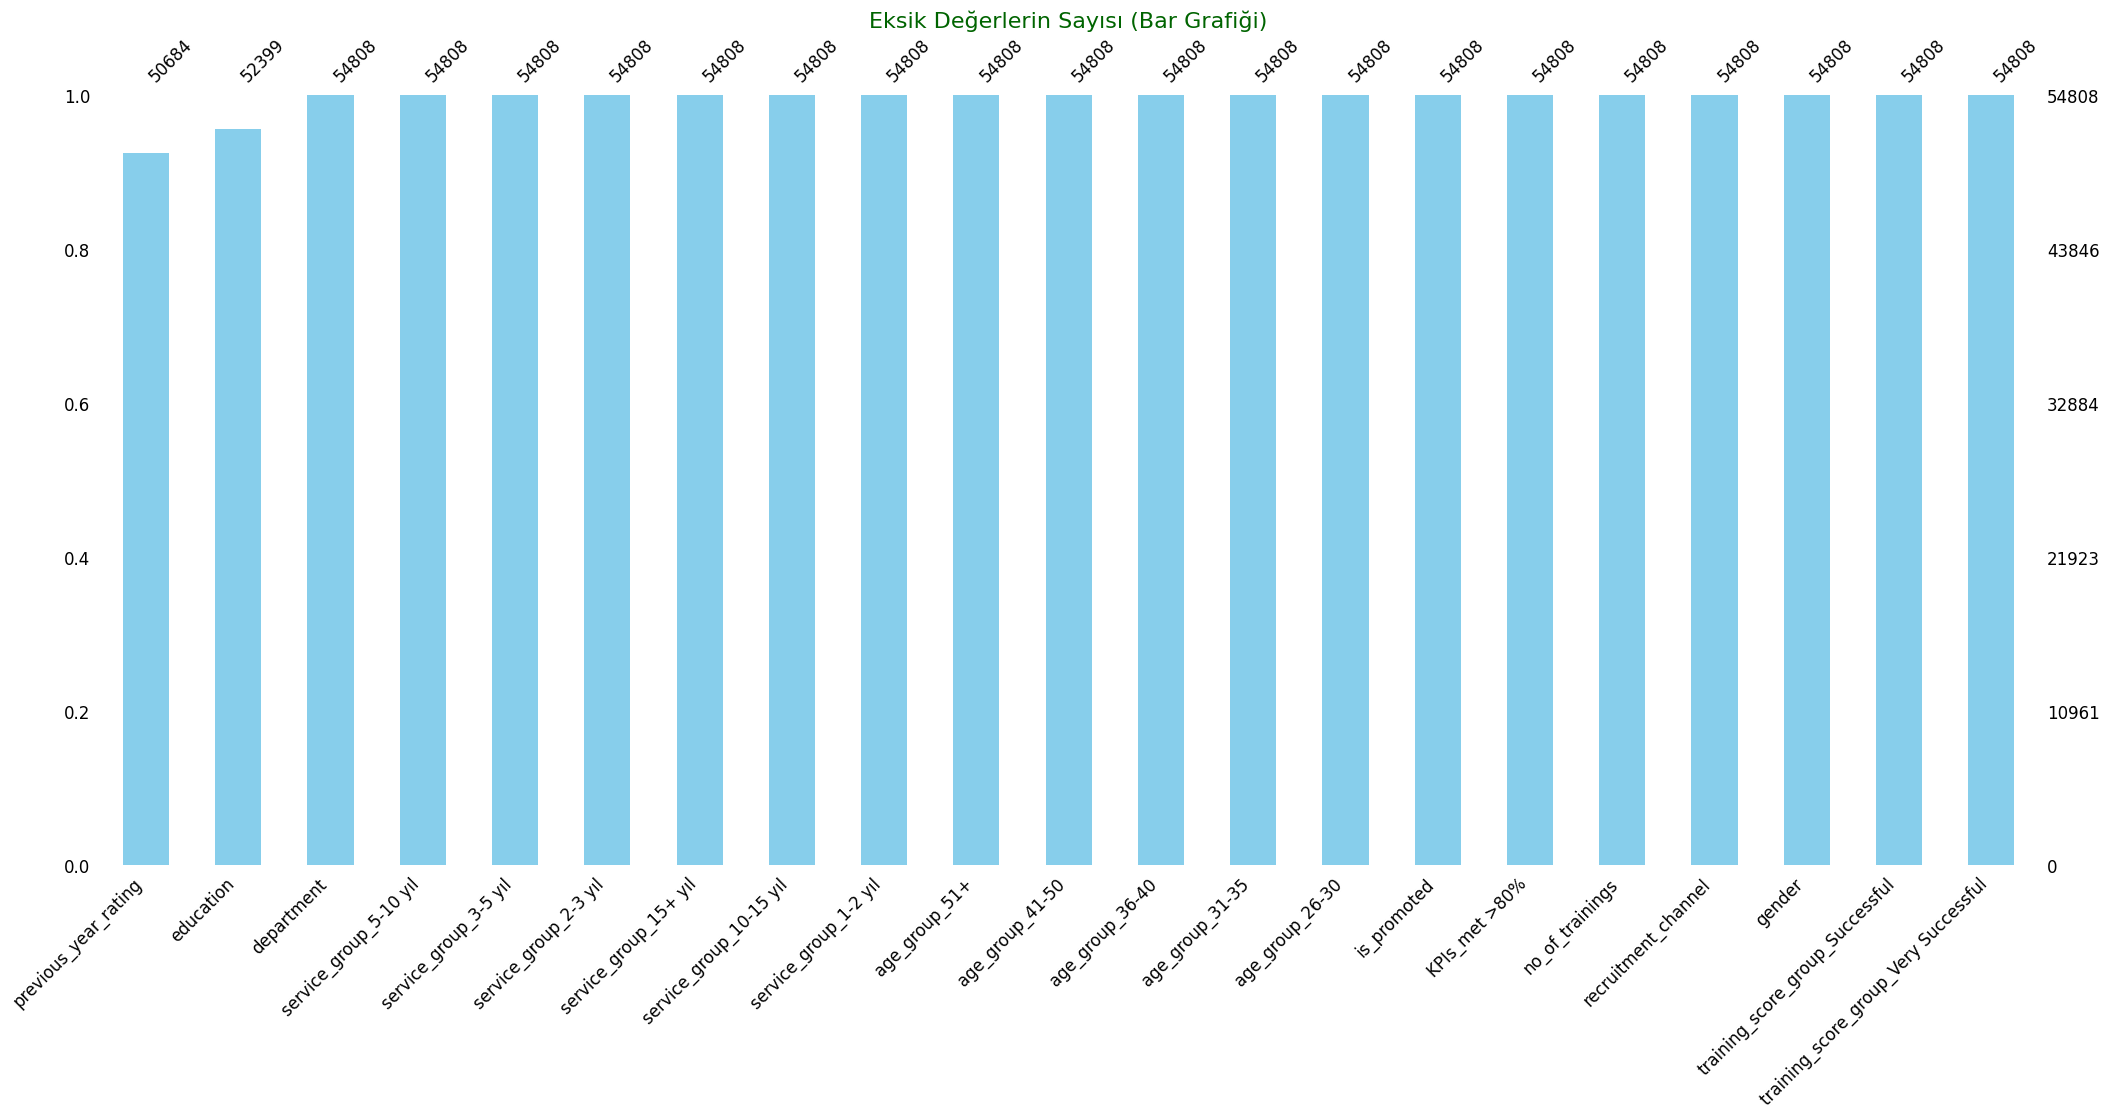

In [29]:
import missingno as msno
import matplotlib.pyplot as plt

# Eksik değerlerin matrisi
plt.figure(figsize=(14, 8))
msno.matrix(data, figsize=(14, 6), fontsize=12, sparkline=True)
plt.title("Eksik Değerlerin Matrisi", fontsize=16, color="darkblue")
plt.show()

# Eksik değerlerin çubuk grafiği
plt.figure(figsize=(10, 6))
msno.bar(data, color='skyblue', fontsize=12, sort="ascending")
plt.title("Eksik Değerlerin Sayısı (Bar Grafiği)", fontsize=16, color="darkgreen")
plt.show()


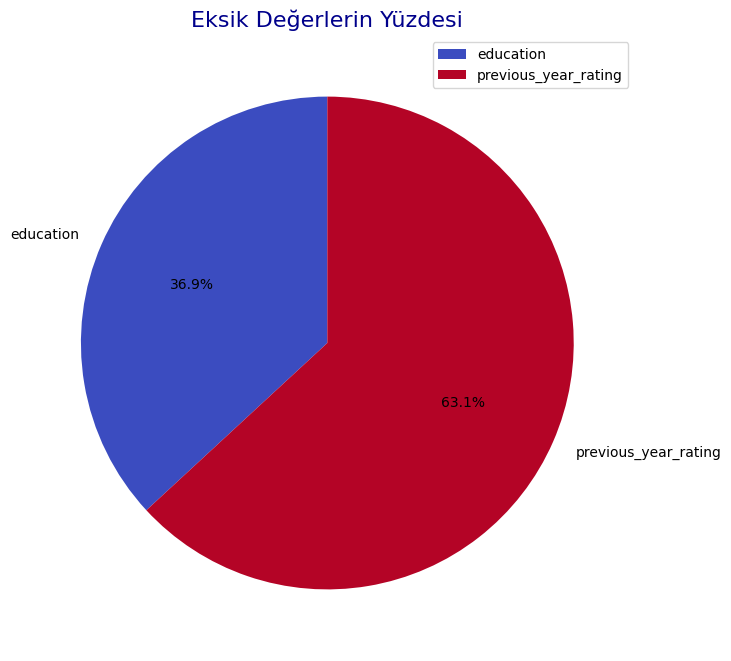

In [30]:
missing_percent = (data.isnull().sum() / len(data)) * 100
missing_percent = missing_percent[missing_percent > 0]

plt.figure(figsize=(8, 8))
missing_percent.plot(kind='pie', autopct='%1.1f%%', startangle=90, cmap='coolwarm', legend=True)
plt.title("Eksik Değerlerin Yüzdesi", fontsize=16, color="darkblue")
plt.ylabel("")  # Yatay eksen yazısını kaldırmak için
plt.show()

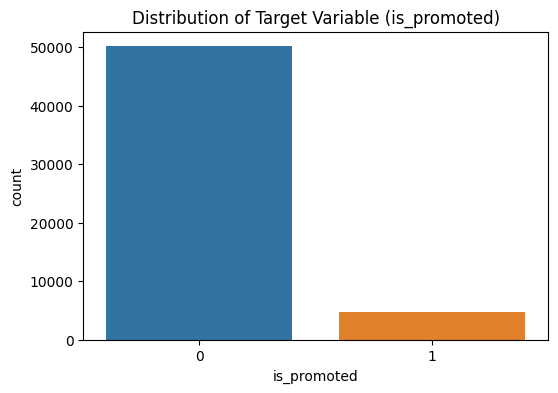

In [31]:
plt.figure(figsize=(6, 4))
sns.countplot(x='is_promoted', data=data)
plt.title('Distribution of Target Variable (is_promoted)')
plt.show()

In [32]:
# Check if there are missing values in categorical features
missing_values_categorical = data.isnull().sum()

print(missing_values_categorical)

missing_values_numerical = data.isnull().sum()

print(missing_values_numerical)



department                                 0
education                               2409
gender                                     0
recruitment_channel                        0
no_of_trainings                            0
previous_year_rating                    4124
KPIs_met >80%                              0
is_promoted                                0
age_group_26-30                            0
age_group_31-35                            0
age_group_36-40                            0
age_group_41-50                            0
age_group_51+                              0
service_group_1-2 yıl                      0
service_group_10-15 yıl                    0
service_group_15+ yıl                      0
service_group_2-3 yıl                      0
service_group_3-5 yıl                      0
service_group_5-10 yıl                     0
training_score_group_Successful            0
training_score_group_Very Successful       0
dtype: int64
department                                

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 21 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   department                            54808 non-null  object 
 1   education                             52399 non-null  object 
 2   gender                                54808 non-null  object 
 3   recruitment_channel                   54808 non-null  object 
 4   no_of_trainings                       54808 non-null  int64  
 5   previous_year_rating                  50684 non-null  float64
 6   KPIs_met >80%                         54808 non-null  int64  
 7   is_promoted                           54808 non-null  int64  
 8   age_group_26-30                       54808 non-null  bool   
 9   age_group_31-35                       54808 non-null  bool   
 10  age_group_36-40                       54808 non-null  bool   
 11  age_group_41-50

In [34]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns


missing_values_table(data, True)


                      n_miss  ratio
previous_year_rating    4124   7.52
education               2409   4.40


['education', 'previous_year_rating']

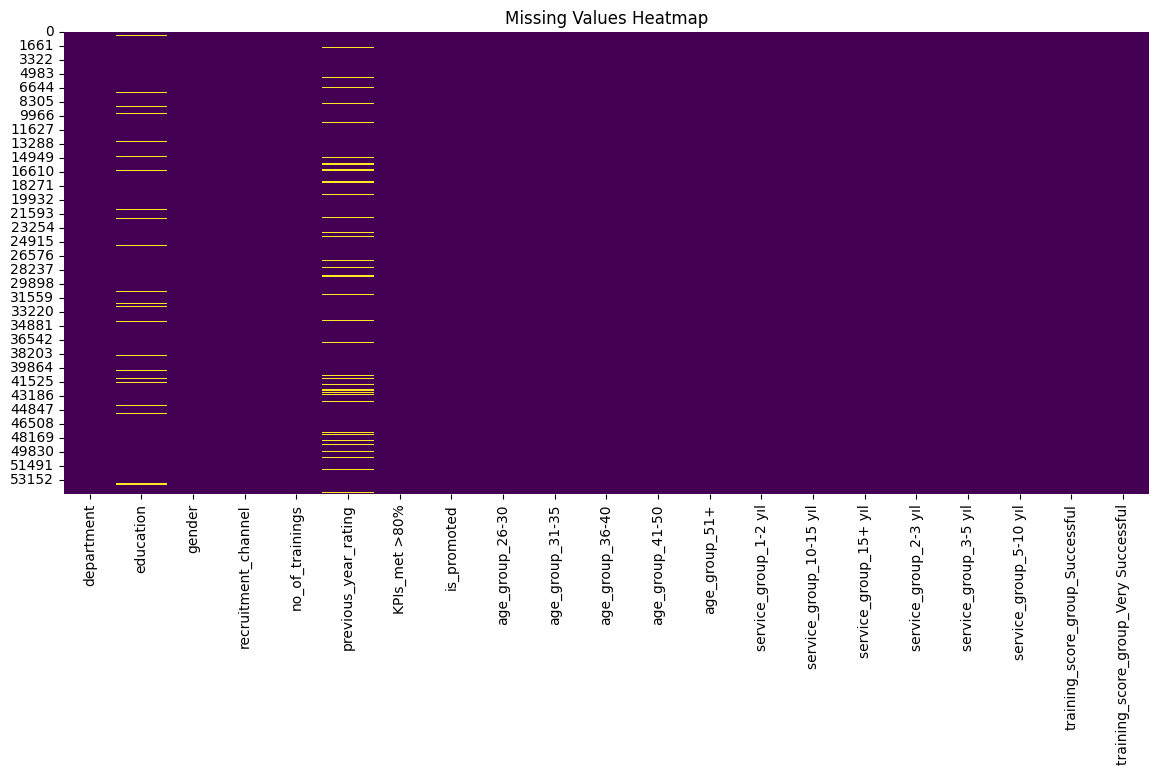

In [35]:
# Visualize missing values
plt.figure(figsize=(14, 6))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 21 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   department                            54808 non-null  object 
 1   education                             52399 non-null  object 
 2   gender                                54808 non-null  object 
 3   recruitment_channel                   54808 non-null  object 
 4   no_of_trainings                       54808 non-null  int64  
 5   previous_year_rating                  50684 non-null  float64
 6   KPIs_met >80%                         54808 non-null  int64  
 7   is_promoted                           54808 non-null  int64  
 8   age_group_26-30                       54808 non-null  bool   
 9   age_group_31-35                       54808 non-null  bool   
 10  age_group_36-40                       54808 non-null  bool   
 11  age_group_41-50

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 21 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   department                            54808 non-null  object 
 1   education                             52399 non-null  object 
 2   gender                                54808 non-null  object 
 3   recruitment_channel                   54808 non-null  object 
 4   no_of_trainings                       54808 non-null  int64  
 5   previous_year_rating                  50684 non-null  float64
 6   KPIs_met >80%                         54808 non-null  int64  
 7   is_promoted                           54808 non-null  int64  
 8   age_group_26-30                       54808 non-null  bool   
 9   age_group_31-35                       54808 non-null  bool   
 10  age_group_36-40                       54808 non-null  bool   
 11  age_group_41-50

In [38]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
no_of_trainings,54808.0,1.253011,0.609264,1.0,1.0,1.0,1.0,10.0
previous_year_rating,50684.0,3.329256,1.259993,1.0,3.0,3.0,4.0,5.0
KPIs_met >80%,54808.0,0.351974,0.477590,0.0,0.0,0.0,1.0,1.0
is_promoted,54808.0,0.085170,0.279137,0.0,0.0,0.0,0.0,1.0


In [39]:
check_df(data)

##################### Shape #####################
(54808, 21)
##################### Types #####################
department                               object
education                                object
gender                                   object
recruitment_channel                      object
no_of_trainings                           int64
previous_year_rating                    float64
KPIs_met >80%                             int64
is_promoted                               int64
age_group_26-30                            bool
age_group_31-35                            bool
age_group_36-40                            bool
age_group_41-50                            bool
age_group_51+                              bool
service_group_1-2 yıl                      bool
service_group_10-15 yıl                    bool
service_group_15+ yıl                      bool
service_group_2-3 yıl                      bool
service_group_3-5 yıl                      bool
service_group_5-10 yıl  

In [40]:
data.nunique()

department                               9
education                                3
gender                                   2
recruitment_channel                      3
no_of_trainings                         10
previous_year_rating                     5
KPIs_met >80%                            2
is_promoted                              2
age_group_26-30                          2
age_group_31-35                          2
age_group_36-40                          2
age_group_41-50                          2
age_group_51+                            2
service_group_1-2 yıl                    2
service_group_10-15 yıl                  2
service_group_15+ yıl                    2
service_group_2-3 yıl                    2
service_group_3-5 yıl                    2
service_group_5-10 yıl                   2
training_score_group_Successful          2
training_score_group_Very Successful     2
dtype: int64

In [41]:
import pandas as pd

# Load the dataset to analyze
file_path = "/kaggle/input/datasonhali/data_son_featured.xlsx"
data = pd.read_excel(file_path)

# Display the first few rows to understand its structure
data.head()

,department,education,gender,recruitment_channel,no_of_trainings,previous_year_rating,KPIs_met >80%,is_promoted,age_group_26-30,age_group_31-35,age_group_36-40,age_group_41-50,age_group_51+,service_group_1-2 yıl,service_group_10-15 yıl,service_group_15+ yıl,service_group_2-3 yıl,service_group_3-5 yıl,service_group_5-10 yıl,training_score_group_Successful,training_score_group_Very Successful
0,Sales & Marketing,Master's & above,f,sourcing,1,5.0,1,0,False,True,False,False,False,False,False,False,False,False,True,False,False
1,Operations,Bachelor's,m,other,1,5.0,0,0,True,False,False,False,False,False,False,False,False,True,False,False,False
2,Sales & Marketing,Bachelor's,m,sourcing,1,3.0,0,0,False,True,False,False,False,False,False,False,False,False,True,False,False
3,Sales & Marketing,Bachelor's,m,other,2,1.0,0,0,False,False,True,False,False,False,False,False,False,False,True,False,False
4,Technology,Bachelor's,m,other,1,3.0,0,0,False,False,False,True,False,True,False,False,False,False,False,True,False


In [42]:
check_df(data)

##################### Shape #####################
(54808, 21)
##################### Types #####################
department                               object
education                                object
gender                                   object
recruitment_channel                      object
no_of_trainings                           int64
previous_year_rating                    float64
KPIs_met >80%                             int64
is_promoted                               int64
age_group_26-30                            bool
age_group_31-35                            bool
age_group_36-40                            bool
age_group_41-50                            bool
age_group_51+                              bool
service_group_1-2 yıl                      bool
service_group_10-15 yıl                    bool
service_group_15+ yıl                      bool
service_group_2-3 yıl                      bool
service_group_3-5 yıl                      bool
service_group_5-10 yıl  

In [43]:
data_info = data.info()
missing_values = data.isnull().sum()
descriptive_stats = data.describe()

# Display the results to understand the data better
data_info, missing_values, descriptive_stats

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 21 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   department                            54808 non-null  object 
 1   education                             52399 non-null  object 
 2   gender                                54808 non-null  object 
 3   recruitment_channel                   54808 non-null  object 
 4   no_of_trainings                       54808 non-null  int64  
 5   previous_year_rating                  50684 non-null  float64
 6   KPIs_met >80%                         54808 non-null  int64  
 7   is_promoted                           54808 non-null  int64  
 8   age_group_26-30                       54808 non-null  bool   
 9   age_group_31-35                       54808 non-null  bool   
 10  age_group_36-40                       54808 non-null  bool   
 11  age_group_41-50

(None,
 department                                 0
 education                               2409
 gender                                     0
 recruitment_channel                        0
 no_of_trainings                            0
 previous_year_rating                    4124
 KPIs_met >80%                              0
 is_promoted                                0
 age_group_26-30                            0
 age_group_31-35                            0
 age_group_36-40                            0
 age_group_41-50                            0
 age_group_51+                              0
 service_group_1-2 yıl                      0
 service_group_10-15 yıl                    0
 service_group_15+ yıl                      0
 service_group_2-3 yıl                      0
 service_group_3-5 yıl                      0
 service_group_5-10 yıl                     0
 training_score_group_Successful            0
 training_score_group_Very Successful       0
 dtype: int64,
        no_o

In [44]:
# 2. Eksik Veri Doldurma
data['education'].fillna(data['education'].mode()[0], inplace=True)
data['previous_year_rating'].fillna(data['previous_year_rating'].median(), inplace=True)

In [45]:
# 3. Kategorik Değişkenleri Kodlama
categorical_columns = ['department', 'education', 'gender', 'recruitment_channel']
categorical_dummy_columns = [col for col in data.columns if col.endswith('group') or col.endswith('Successful')]
all_categorical_columns = categorical_columns + categorical_dummy_columns
data_encoded = pd.get_dummies(data, columns=all_categorical_columns, drop_first=True)

In [46]:
# 4. Sayısal Değişkenleri Ölçeklendirme
numerical_columns = ['no_of_trainings', 'previous_year_rating', 'KPIs_met >80%']
scaler = StandardScaler()
data_encoded[numerical_columns] = scaler.fit_transform(data_encoded[numerical_columns])

In [47]:
# 5. Veri Setini Ayırma
X = data_encoded.drop(columns=['is_promoted'])
y = data_encoded['is_promoted']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, stratify=y, random_state=42)

# 6. SMOTE ile Dengesizlik Çözümü
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [48]:
def base_models(X_train, y_train, scoring="roc_auc"):
    print("Base Models....")
    classifiers = [('LR', LogisticRegression()),
                   ('KNN', KNeighborsClassifier()),
                   ("SVC", SVC()),
                   ("CART", DecisionTreeClassifier()),
                   ("RF", RandomForestClassifier()),
                   ('Adaboost', AdaBoostClassifier()),
                   ("XGBoost", XGBClassifier( use_label_encoder=False, eval_metric="logloss")),
                   ("LightGBM", LGBMClassifier()),
                   ("CatBoost", CatBoostClassifier(verbose=0))                 
                   
                   ]
                  
    

    for name, classifier in classifiers:
        cv_results = cross_validate(classifier,X_train, y_train, cv=3, scoring=scoring)
        print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name}) ")
    

base_models(X_train, y_train, scoring="accuracy") 

##  LR - CART - RF -XGBOOST -LİGTHGM

Base Models....
accuracy: 0.9236 (LR) 
accuracy: 0.9121 (KNN) 
accuracy: 0.9303 (SVC) 
accuracy: 0.9066 (CART) 
accuracy: 0.9157 (RF) 
accuracy: 0.9196 (Adaboost) 
accuracy: 0.9289 (XGBoost) 
[LightGBM] [Info] Number of positive: 2178, number of negative: 23398
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010920 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 97
[LightGBM] [Info] Number of data points in the train set: 25576, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085158 -> initscore=-2.374244
[LightGBM] [Info] Start training from score -2.374244
[LightGBM] [Info] Number of positive: 2179, number of negative: 23398
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007755 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not 

[LightGBM] [Info] Number of positive: 3268, number of negative: 35097
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012448 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 98
[LightGBM] [Info] Number of data points in the train set: 38365, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085182 -> initscore=-2.373937
[LightGBM] [Info] Start training from score -2.373937


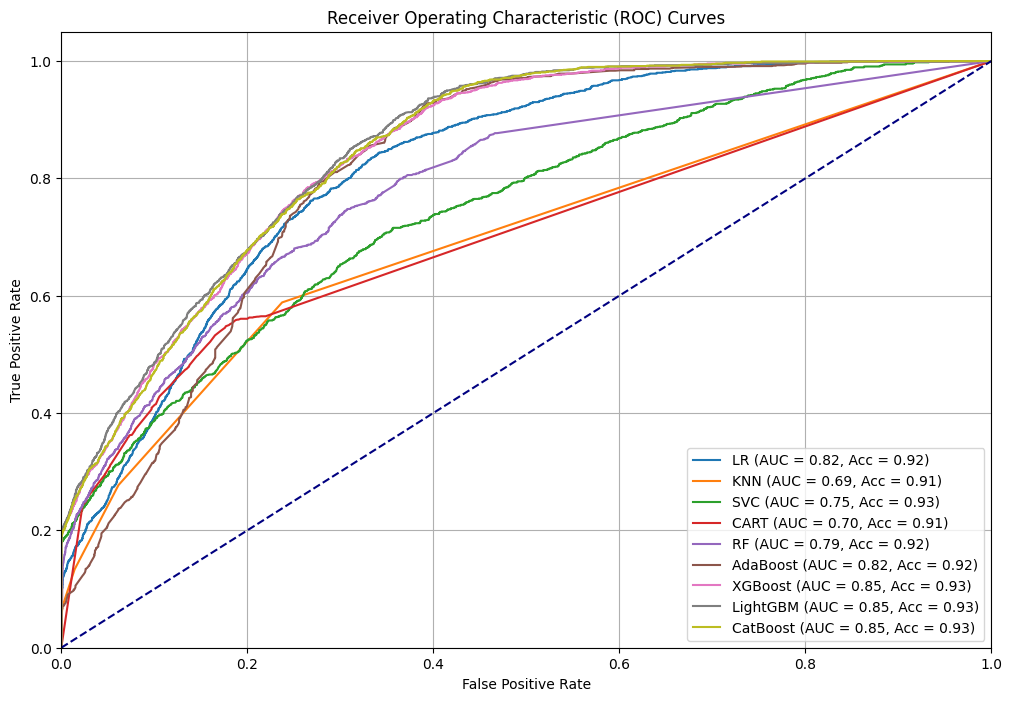

In [49]:
from sklearn.metrics import roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

def plot_roc_curves(X_train, X_test, y_train, y_test):
    classifiers = [
        ('LR', LogisticRegression()),
        ('KNN', KNeighborsClassifier()),
        ('SVC', SVC(probability=True)),  # probability=True is needed for ROC curve
        ('CART', DecisionTreeClassifier()),
        ('RF', RandomForestClassifier()),
        ('AdaBoost', AdaBoostClassifier()),
        ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric="logloss")),
        ('LightGBM', LGBMClassifier()),
        ('CatBoost', CatBoostClassifier(verbose=0))
    ]

    plt.figure(figsize=(12, 8))
    for name, classifier in classifiers:
        # Fit the classifier
        classifier.fit(X_train, y_train)
        
        # Predict probabilities
        y_proba = classifier.predict_proba(X_test)[:, 1]
        y_pred = classifier.predict(X_test)
        
        # Compute ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        
        # Compute accuracy
        acc = accuracy_score(y_test, y_pred)
        
        # Plot ROC curve
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f}, Acc = {acc:.2f})')
    
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

# Example usage (assuming SMOTE and train-test split have been applied)
plot_roc_curves(X_train, X_test, y_train, y_test)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 35097, number of negative: 35097
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5058
[LightGBM] [Info] Number of data points in the train set: 70194, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


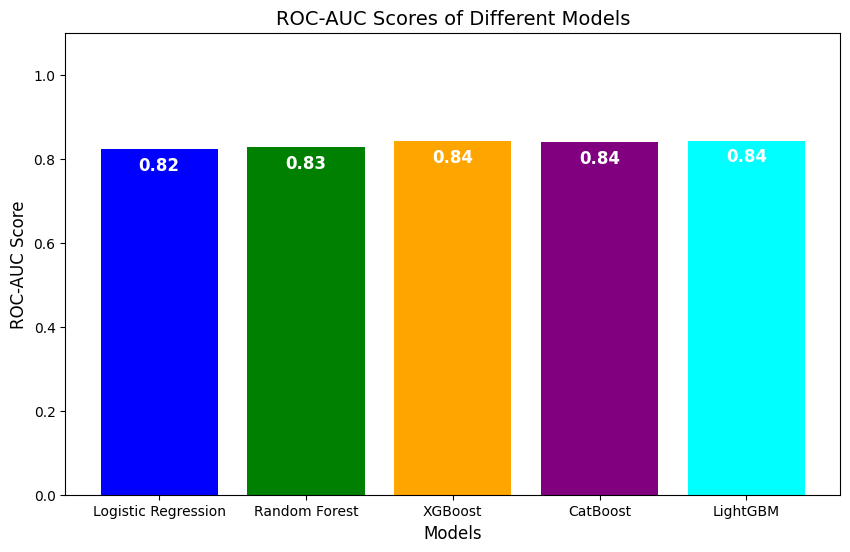

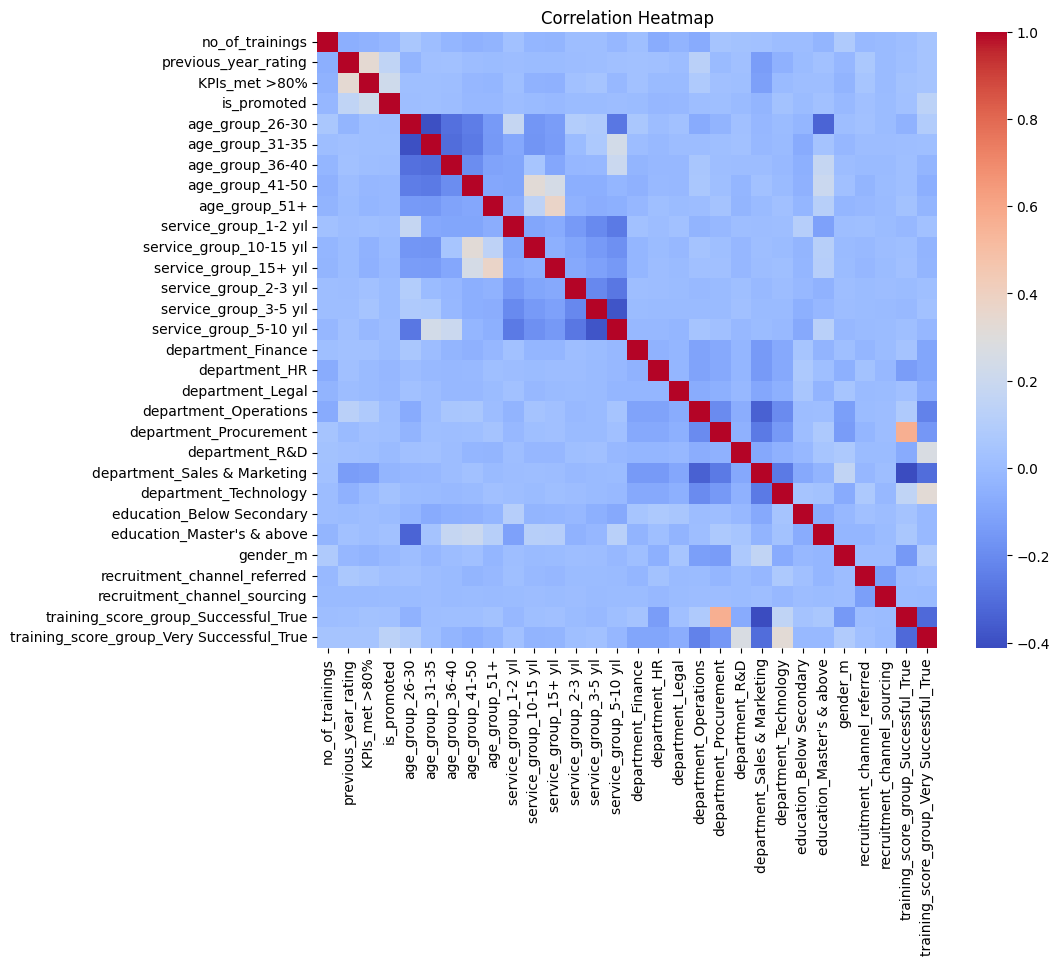

In [50]:
# 7. Logistic Regression
logistic_model = LogisticRegression(random_state=42, max_iter=1000)
logistic_model.fit(X_train_smote, y_train_smote)
y_pred_log = logistic_model.predict(X_test)
y_pred_proba_log = logistic_model.predict_proba(X_test)[:, 1]
log_auc = roc_auc_score(y_test, y_pred_proba_log)

# 8. Random Forest
rf_model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
rf_model.fit(X_train_smote, y_train_smote)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]
rf_auc = roc_auc_score(y_test, y_pred_proba_rf)

# 9. XGBoost
xgb_model = XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_smote, y_train_smote)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]
xgb_auc = roc_auc_score(y_test, y_pred_proba_xgb)

# 10. CatBoost
cat_model = CatBoostClassifier(iterations=500, depth=6, learning_rate=0.1, l2_leaf_reg=3, random_state=42, verbose=0, eval_metric='AUC')
cat_model.fit(X_train_smote, y_train_smote)
y_pred_proba_cat = cat_model.predict_proba(X_test)[:, 1]
cat_auc = roc_auc_score(y_test, y_pred_proba_cat)

# 11. LightGBM
lgbm_model = LGBMClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42)
lgbm_model.fit(X_train_smote, y_train_smote)
y_pred_proba_lgbm = lgbm_model.predict_proba(X_test)[:, 1]
lgbm_auc = roc_auc_score(y_test, y_pred_proba_lgbm)

# 12. ROC-AUC Skorlarını Görselleştirme
models = ['Logistic Regression', 'Random Forest', 'XGBoost', 'CatBoost', 'LightGBM']
roc_auc_scores = [log_auc, rf_auc, xgb_auc, cat_auc, lgbm_auc]

plt.figure(figsize=(10, 6))
bars = plt.bar(models, roc_auc_scores, color=['blue', 'green', 'orange', 'purple', 'cyan'])
plt.title('ROC-AUC Scores of Different Models', fontsize=14)
plt.ylabel('ROC-AUC Score', fontsize=12)
plt.xlabel('Models', fontsize=12)
plt.ylim(0, 1.1)

for bar, score in zip(bars, roc_auc_scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.05, f'{score:.2f}', 
             ha='center', color='white', fontsize=12, weight='bold')

plt.show()

# 13. Korelasyon Heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = data_encoded.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt='.2f', annot=False)
plt.title('Correlation Heatmap')
plt.show()

# 14. Confusion Matrix for Logistic Regression
# cm = confusion_matrix(y_test, logistic_model.predict(X_test))
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Promoted', 'Promoted'])
# disp.plot(cmap='Blues')
# plt.title('Confusion Matrix for Logistic Regression')
# plt.show()

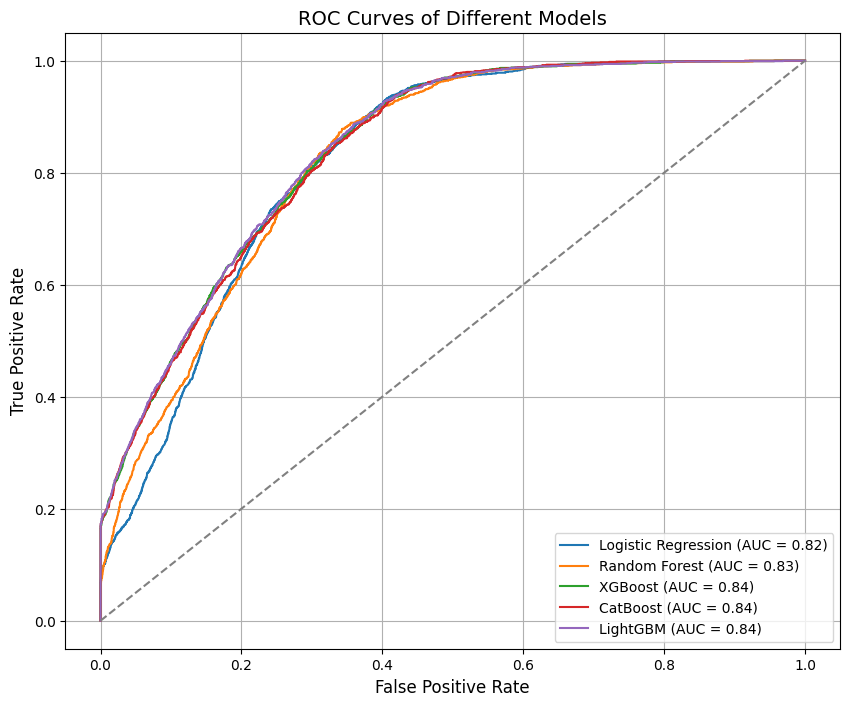

In [51]:
# ROC Eğrisi
plt.figure(figsize=(10, 8))

# Logistic Regression
fpr_log, tpr_log, _ = roc_curve(y_test, y_pred_proba_log)
plt.plot(fpr_log, tpr_log, label=f'Logistic Regression (AUC = {log_auc:.2f})')

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {rf_auc:.2f})')

# XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {xgb_auc:.2f})')

# CatBoost
fpr_cat, tpr_cat, _ = roc_curve(y_test, y_pred_proba_cat)
plt.plot(fpr_cat, tpr_cat, label=f'CatBoost (AUC = {cat_auc:.2f})')

# LightGBM
fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test, y_pred_proba_lgbm)
plt.plot(fpr_lgbm, tpr_lgbm, label=f'LightGBM (AUC = {lgbm_auc:.2f})')

# Grafik Ayarları
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Rastgele tahmin
plt.title('ROC Curves of Different Models', fontsize=14)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)
plt.show()

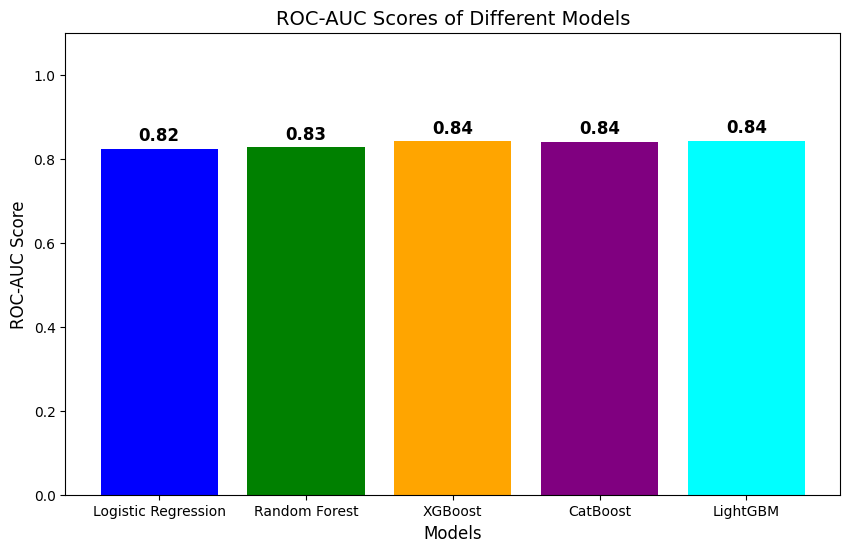

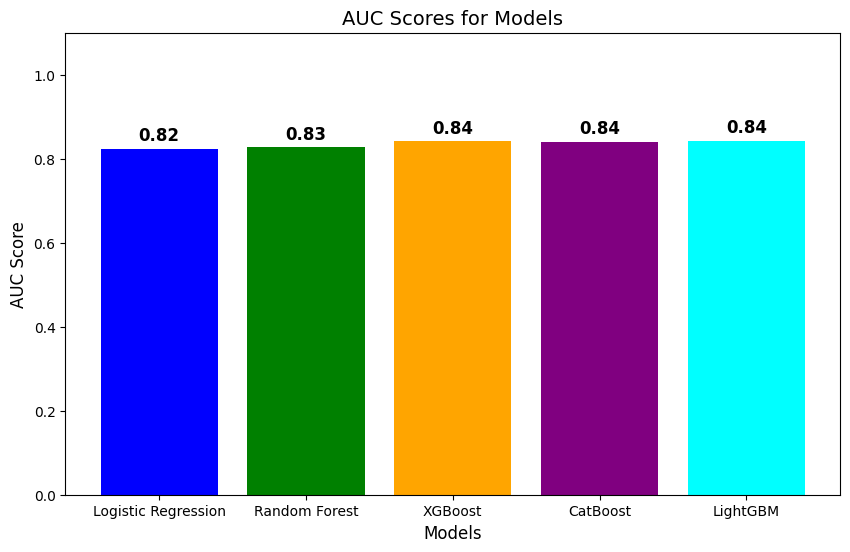

In [52]:
import matplotlib.pyplot as plt

# Model isimleri ve AUC skorları
models = ['Logistic Regression', 'Random Forest', 'XGBoost', 'CatBoost', 'LightGBM']
roc_auc_scores = [log_auc, rf_auc, xgb_auc, cat_auc, lgbm_auc]

# 1. ROC-AUC skorlarının bar grafiği
plt.figure(figsize=(10, 6))
bars = plt.bar(models, roc_auc_scores, color=['blue', 'green', 'orange', 'purple', 'cyan'])
plt.title('ROC-AUC Scores of Different Models', fontsize=14)
plt.ylabel('ROC-AUC Score', fontsize=12)
plt.xlabel('Models', fontsize=12)
plt.ylim(0, 1.1)  # Y eksenini 0 ile 1 arasında tutalım

# AUC değerlerini barların üzerinde göstermek
for bar, score in zip(bars, roc_auc_scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02, f'{score:.2f}', 
             ha='center', color='black', fontsize=12, weight='bold')

# ROC-AUC bar grafiği göster
plt.show()

# 2. Ayrı bir grafikte sadece AUC skorlarını yazdırma
plt.figure(figsize=(10, 6))
plt.bar(models, roc_auc_scores, color=['blue', 'green', 'orange', 'purple', 'cyan'])
plt.title('AUC Scores for Models', fontsize=14)
plt.ylabel('AUC Score', fontsize=12)
plt.xlabel('Models', fontsize=12)
plt.ylim(0, 1.1)  # Y eksenini 0 ile 1 arasında tutalım

# AUC skorlarını metin olarak göstermek
for i, score in enumerate(roc_auc_scores):
    plt.text(i, score + 0.02, f'{score:.2f}', ha='center', fontsize=12, weight='bold')

plt.show()


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


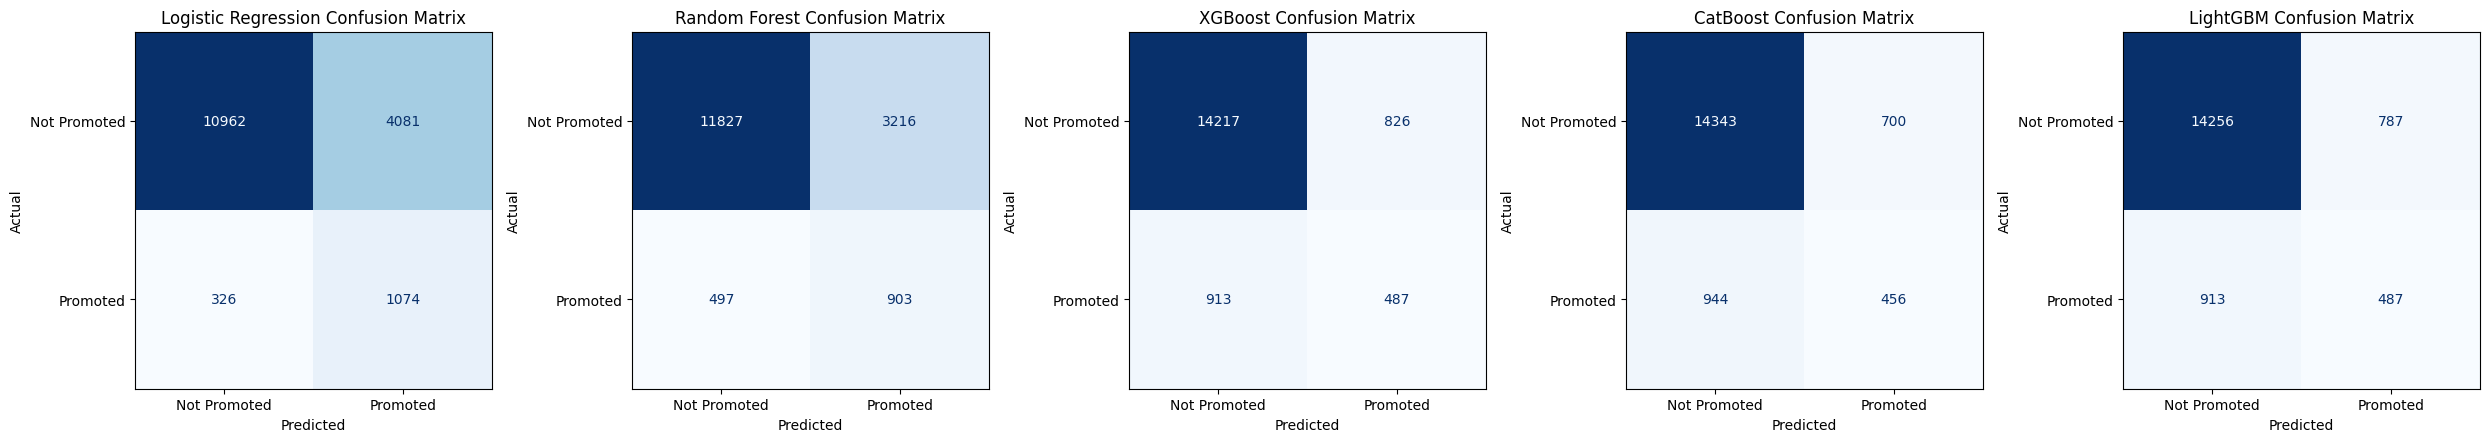

In [53]:
models = {
    'Logistic Regression': logistic_model,
    'Random Forest': rf_model,
    'XGBoost': xgb_model,
    'CatBoost': cat_model,
    'LightGBM': lgbm_model
}

# Grafik boyutunu ayarlayın
fig, axes = plt.subplots(1, 5, figsize=(25, 5))

# Her bir model için confusion matrix çizelim
for idx, (model_name, model) in enumerate(models.items()):
    cm = confusion_matrix(y_test, model.predict(X_test))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Promoted', 'Promoted'])
    ax = axes[idx]
    disp.plot(ax=ax, cmap='Blues', colorbar=False)
    ax.set_title(f'{model_name} Confusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()